![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [ ]:
# Run the cells below first

In [ ]:
!pip install torchmetrics
!pip install torchvision

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

In [ ]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

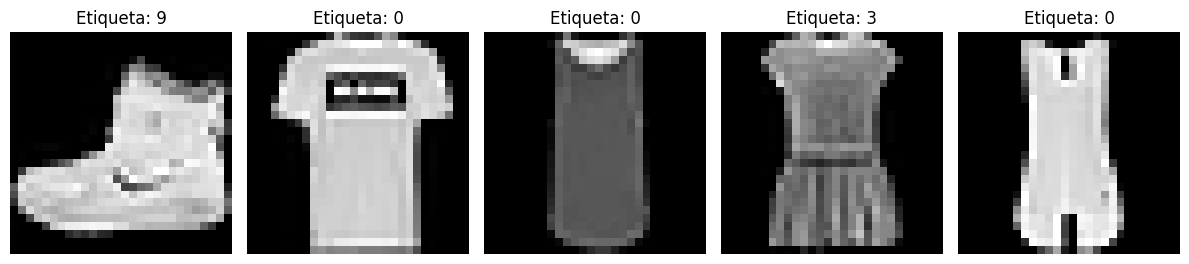

In [ ]:
# Muestro 5 imágenes y etiquetas del dataset
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i in range(5):
    image, label = train_data[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Etiqueta: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Obtener todas las etiquetas del dataset de entrenamiento
labels = [label for _, label in train_data]

# Contar cuántas imágenes hay por clase
from collections import Counter
print(Counter(labels))


Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


Esto quiere decir que hay 6000 muestras de ropa para todas las categorías (Desde la 0 hasta la 9)

Que tipo de ropa representa cada etiqueta?

Etiqueta	Clase (Categoría de ropa)
0	        T-shirt/top (Camiseta)
1	        Trouser (Pantalón)
2	        Pullover (Suéter)
3	        Dress (Vestido)
4	        Coat (Abrigo)
5	        Sandal (Sandalia)
6	        Shirt (Camisa)
7	        Sneaker (Zapatilla)
8	        Bag (Bolso)
9	        Ankle boot (Bota baja)

Que tipo de ropa representa cada etiqueta?

In [ ]:
import pandas as pd

labels_map = {
    0: "T-shirt/top (Camiseta)",
    1: "Trouser (Pantalón)",
    2: "Pullover (Suéter)",
    3: "Dress (Vestido)",
    4: "Coat (Abrigo)",
    5: "Sandal (Sandalia)",
    6: "Shirt (Camisa)",
    7: "Sneaker (Zapatilla)",
    8: "Bag (Bolso)",
    9: "Ankle boot (Bota baja)"
}

# Convertir a un DataFrame
df_labels = pd.DataFrame(list(labels_map.items()), columns=["Etiqueta", "Clase (Categoría de ropa)"])

# Mostrar el DataFrame como tabla
df_labels


,Etiqueta,Clase (Categoría de ropa)
0,0,T-shirt/top (Camiseta)
1,1,Trouser (Pantalón)
2,2,Pullover (Suéter)
3,3,Dress (Vestido)
4,4,Coat (Abrigo)
5,5,Sandal (Sandalia)
6,6,Shirt (Camisa)
7,7,Sneaker (Zapatilla)
8,8,Bag (Bolso)
9,9,Ankle boot (Bota baja)


**Ahora definimos la red convolucional**

In [ ]:
#Obtenemos el numero de clases
classes = train_data.classes
num_classes = len(train_data.classes)
print(num_classes)
image_size = train_data[0][0].shape[1] #Necesito saber las dimensiones de la imagen para ingresarlo como dato de entrada en la capa de conexión comnpleta

10


In [ ]:
class NetCNN(nn.Module):
    def __init__(self, num_classes):
        super(NetCNN, self).__init__()
        #Primer y unico bloque convolucional
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1,padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        #Capa completa conectada
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features= (32 * (image_size//2) ** 2), out_features= num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        #Primer bloque
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)

        #Conexion completa
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

**Ahora entrenamos el modelo**

In [ ]:
#Creamos el Dataloader para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
#Shuffle sirve para mezclar los datos aleatoriamente en cada época durante el entrenamiento
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

def entrenar_modelo(optimizer, model, num_epocas):
    num_procesado = 0
    criterion = nn.CrossEntropyLoss()
    for epoca in range(num_epocas):
        running_loss = 0
        num_procesado = 0
        for images, labels in train_loader:
            #Inicializamos los gradientes a cero
            optimizer.zero_grad()
            #Pasar las imágenes por el modelo
            outputs = modelo_cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_procesado += len(labels)

        print(f'epoch {epoca}, loss: {running_loss / num_procesado}')

    train_loss = running_loss / len(train_loader)

# Entrenarlo para una época
modelo_cnn = NetCNN(num_classes)
#Definimos el criterio de perdida
optimizer = optim.Adam(modelo_cnn.parameters(), lr=0.001)

entrenar_modelo(
    optimizer=optimizer,
    model=modelo_cnn,
    num_epocas=1,
)


epoch 0, loss: 0.17101956820885342


**Ahora evaluamos las metricas**

In [ ]:
metric_precision = Precision(
    task="multiclass", num_classes=10, average="macro"
)
metric_recall = Recall(
    task="multiclass", num_classes=10, average="macro"
)
metric_accuracy = Accuracy(
    task="multiclass", num_classes=10, average="macro"
)

predictions = []
precisions = []  # Nueva lista para almacenar los valores de precisión por lote

modelo_cnn.eval()
with torch.no_grad():
    for images1, labels in test_loader:
        outputs = modelo_cnn(images1)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())
        metric_precision(preds, labels)
        metric_recall(preds, labels)
        metric_accuracy(preds, labels)
        # Guardar la precisión de este lote como un valor en la lista
        precisions.append(metric_precision.compute().item())

#Publicamos las métricas
precision = metric_precision.compute().item()
recall = metric_recall.compute().tolist()
accuracy = metric_accuracy.compute().tolist()
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

#Mostramos las primeras predicciones
print(predictions[:10])

# Mostramos la lista de precisiones por lote
print(f"Precisions por lote: {precisions}")

Precision: 0.7486910223960876
Recall: 0.8095000386238098
Accuracy: 0.8095000386238098
[9, 2, 1, 1, 6, 1, 6, 6, 5, 7]
Precisions por lote: [0.8095238208770752, 0.7500000596046448, 0.68452388048172, 0.7395238280296326, 0.6877777576446533, 0.6969192028045654, 0.6787374019622803, 0.6982234120368958, 0.7230799794197083, 0.7216594219207764, 0.727237343788147, 0.7399939298629761, 0.7468304634094238, 0.74161297082901, 0.7409430742263794, 0.7272030115127563, 0.7299384474754333, 0.7368114590644836, 0.7328001260757446, 0.7434810400009155, 0.7459217309951782, 0.7477135062217712, 0.7515129446983337, 0.7509985566139221, 0.7541610598564148, 0.7549332976341248, 0.7593734860420227, 0.7601339817047119, 0.7625615000724792, 0.7654666304588318, 0.7664157152175903, 0.7631231546401978, 0.7642850875854492, 0.7636366486549377, 0.7589143514633179, 0.7598145008087158, 0.7609805464744568, 0.7598152756690979, 0.7597078680992126, 0.7606647610664368, 0.7577268481254578, 0.756001353263855, 0.7560758590698242, 0.75522

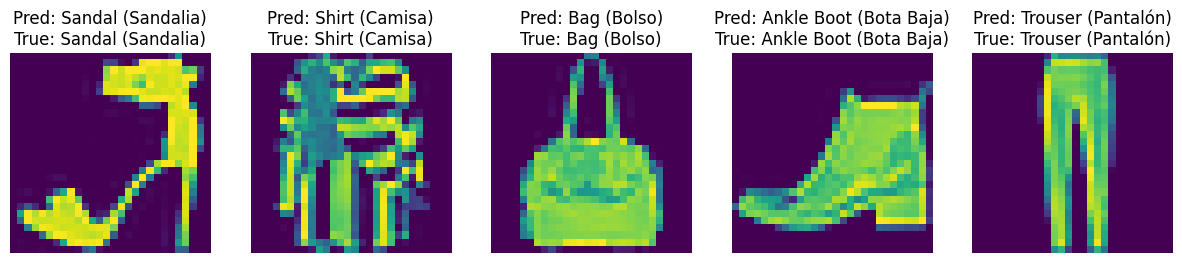

In [ ]:
# Transformaciones para revertir las operaciones hechas en el dataset
inv_normalize = transforms.Normalize(
    mean=[-0.5 / 0.5],  # Normalización inversa
    std=[1 / 0.5]
)
# Etiquetas de las clases (ajústalas según tu dataset)
class_labels = [
    "T-shirt/top (Camiseta)", "Trouser (Pantalón)", "Pullover (Suéter)", "Dress (Vestido)", "Coat (Abrigo)",
    "Sandal (Sandalia)", "Shirt (Camisa)", "Sneaker (Zapatilla)", "Bag (Bolso)", "Ankle Boot (Bota Baja)"
]

# Visualizar las imágenes con las predicciones
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Mostrar 5 imágenes
for i in range(5):
    image = images1[i]
    # Revertir la normalización para mostrar la imagen original
    image = inv_normalize(image)
    image = image.permute(1, 2, 0).numpy()  # Cambiar formato a HWC para matplotlib

    # Mostrar la imagen
    axes[i].imshow(image)
    axes[i].axis("off")
    # Agregar la etiqueta de predicción
    pred_label = class_labels[preds[i].item()]
    true_label = class_labels[labels[i].item()]
    axes[i].set_title(f"Pred: {pred_label}\nTrue: {true_label}")

plt.show()